# Regresión Lineal usando Gradiente Descendente




___

## Introducción

Los modelos de regresión lineal son un buen punto de partida para las tareas de regresión y para entender varios conceptos. En este notebook, implementaremos regresión lineal desde cero, usando métodos y operaciones básicas sobre areglos de Numpy.

## Importación de bibliotecas

Comencemos con las importaciones de bibliotecas estándar:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random # para números aleatorios

## Seeds para reproducibilidad

Fijamos el `seed` que permitirá reproducir los resultados obtenidos.

In [ ]:
def set_seed(seed=None):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    print(f'Semilla {seed} ha sido asignada.')

set_seed(42)

Semilla 42 ha sido asignada.


## Generación del conjunto de datos

Antes de iniciar con las implementación, generaremos un conjunto de datos. Para simplificar las cosas, construiremos un conjunto de datos artificial. Nuestra tarea será recuperar los parámetros de este modelo utilizando el conjunto finito de ejemplos contenidos en nuestro conjunto de datos. Mantendremos los datos de dimensiones reducidas para que podamos visualizarlos fácilmente.

En el siguiente fragmento de código, generamos un conjunto de datos que contiene 1000 muestras, cada uno de los cuales consta de 1 característica extraída de una distribución normal estándar. Por lo tanto, nuestro conjunto de datos sintéticos será una matriz $\mathbf{X}\in \mathbb{R}^{1000 \times 1}$.

In [ ]:
def synthetic_data(w, b, num_examples):
    """Generar y = Xw + b + noise."""
    X = np.random.randn(num_examples, len(w)) * 2
    y = np.matmul(X, w) + b
    y += np.random.randn(*y.shape)
    return X, y.reshape(-1, 1)

Los verdaderos parámetros que generan nuestro conjunto de datos serán
$\mathbf{w} = [1.5]^\top$ y $b = 4.2$:

In [ ]:
true_w = np.array([1.5])
true_b = 4.2
X, y = synthetic_data(true_w, true_b, 1200)

Declaramos a $\mathbf{w}$ como un vector ya que nos permitirá generalizar el modelo a más de una característica. Ahora, visualicemos la data generada:

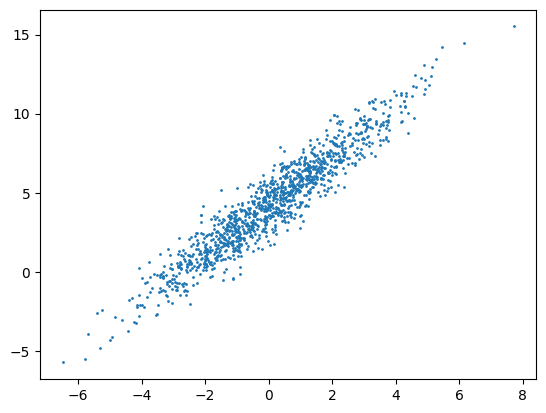

In [ ]:
plt.scatter(X, y, 1);

Podemos observar claramente la relación lineal entre la data de entrada y el valor objetivo.

## Particionamiento de datos

Particionaremos los datos de tal forma que los últimos $200$ serán para la data de prueba y los primeros $1000$ para la data de entrenamiento. En este ejemplo simple no consideraremos data de validación. En ejercicios futuros si haremos el particionamiento considerando data de validación.

In [ ]:
def data_split(X, y, train_size):
    # TODO: Particionar la data de tal forma que los primeros elementos
    #       dados por train_size formen parte de la data de entrenamiento
    #       y el resto forme parte de la data de prueba
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = data_split(X, y, 1000)
print("Tamano de la data de entrenamiento:", X_train.shape, y_train.shape)
print("Tamano de la data de prueba:", X_test.shape, y_test.shape)

Tamano de la data de entrenamiento: (1000, 1) (1000, 1)
Tamano de la data de prueba: (200, 1) (200, 1)


## Regresión Lineal desde cero

En esta sección implementaremos todo el método desde cero, incluyendo el modelo, la función de pérdida y el optimizador de gradiente descendente. Si bien los frameworks de deep learning modernos pueden automatizar casi todo este trabajo, implementar las cosas desde cero es la única forma de asegurarnos de que realmente sabemos lo que estamos haciendo.

Además, cuando llega el momento de personalizar modelos, definir nuestras propias capas o funciones de pérdida, comprender cómo funcionan las cosas por debajo resultará útil. En esta sección, nos basaremos solo en arreglos de Numpy. Luego, presentaremos una implementación usando scikit-learn

### Modelo Lineal

Dado un conjunto de datos, nuestro objetivo es elegir los pesos $\mathbf {w}$ y el bias $b$ de manera que, en promedio, las predicciones realizadas según nuestro modelo se ajusten mejor a los valores reales observados en los datos. Los modelos cuya predicción de salida está determinada por la transformación afín de las características de entrada son *modelos lineales*, donde la transformación afín se especifica mediante las ponderaciones y el bias elegidos.

En machine learning, generalmente trabajamos con conjuntos de datos de alta dimensión, por lo que es más conveniente emplear la notación de álgebra lineal. Cuando nuestras entradas constan de características $m$,
expresamos nuestra predicción $\hat{y}$ (en general, el símbolo "sombrero" denota estimaciones) como

$$\hat{y} = w_1 x_1 + ... + w_m x_m + b.$$

Donde el vector $\mathbf{x}$ corresponde a las características de una única muestra de datos. A menudo nos resultará conveniente hacer referencia a las características de nuestro conjunto de datos completo de $n$ muestras a través de la *matriz de diseño* $\mathbf{X} \in \mathbb{R}^{n \times m} $. Aquí, $\mathbf{X}$ contiene una fila para cada muestra y una columna para cada característica.

Para una colección de características $\mathbf{X}$, las predicciones $\hat {\mathbf{y}} \in \mathbb{R}^n$ se pueden expresar a través del producto matriz-vector:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$

donde se aplica `broadcasting` durante la suma. Dadas las características de un conjunto de datos de entrenamiento $\mathbf{X}$ y las etiquetas correspondientes (conocidas) $\mathbf{y}$, el objetivo de la regresión lineal es encontrar el vector de peso $\mathbf{w}$ y el bias $b$ que dadas las características de un nuevo ejemplo de datos muestreados de la misma distribución que $\mathbf{X}$, la etiqueta del nuevo ejemplo se predecirá (en promedio) con el error más bajo.


### Función de Pérdida

Antes de empezar a pensar en cómo *ajustar* los datos a nuestro modelo, necesitamos determinar una medida de error. La *función de pérdida* cuantifica la distancia entre el valor *real* y *predicho* del objetivo. La pérdida generalmente será un número no negativo donde los valores más pequeños son mejores y las predicciones perfectas incurren en una pérdida de 0. La función de pérdida más popular en los problemas de regresión es el error al cuadrado. Cuando nuestra predicción para un ejemplo $ i $ es $ \hat{y}^{(i)} $ y la etiqueta verdadera correspondiente es $y^{(i)}$, el error al cuadrado viene dado por:

$$ l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left (\hat {y}^{(i)} - y^{(i)} \right)^ 2. $$

La constante $\frac{1}{2}$ no hace ninguna diferencia real, pero resultará notablemente conveniente, y se cancelará cuando tomemos la derivada de la función de pérdida. Visualmente el objetivo es encontrar la línea que mejor se ajuste a los datos, minimizando el error, como lo mostrado en la imagen a continuación:

<p align="center">
  <img src = "https://d2l.ai/_images/fit-linreg.svg" >
<p/>

Tenga en cuenta que las grandes diferencias entre estimaciones $\hat{y}^{(i)}$ y observaciones $y^{(i)}$ conducen a contribuciones aún mayores a la pérdida, debido a la dependencia cuadrática. Para medir la calidad de un modelo en todo el conjunto de datos de $n$ ejemplos, simplemente promediamos (o equivalentemente, sumamos) las pérdidas en el conjunto de entrenamiento

$$\mathcal{L}(\mathbf{w}, b) =\frac{1}{n}\sum_{i=0}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=0}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

Al entrenar el modelo, queremos encontrar parámetros ($ \mathbf{w}^*,b^*$) que minimizan la pérdida total en todos los ejemplos de entrenamiento:

$$\mathbf{w}^*, b^* = \operatorname * {arg min}_{\mathbf{w}, b} \mathcal{L} (\mathbf{w}, b). $$

*Un nombre más conocido para esta función de pérdida es error cuadrático medio (mean squared error - MSE)*

### Definición de la función de pérdida

Como lo descrito anteriormente usaremos la función de pérdida de error cuadrático medio (MSE). En la implementación, necesitamos transformar el valor verdadero $y$ para que tenga el mismo tamaño del valor predicho $\hat y$. El resultado devuelto por la siguiente función también tendrá el mismo tamaño que $\hat y$.

In [ ]:
def mse(y_true, y_pred):
    # TODO: Implemente la función de pérdida MSE usando vectorización
    error = (y_true - y_pred)**2
    return error.mean()

In [ ]:
error = mse(np.array([1, 4, 3]), np.array([1, 3, 4]))
print(f'MSE de ejemplo: {error}')

MSE de ejemplo: 0.6666666666666666


### Solución iterativa

En sesiones anteriores vimos que podemos usar la solución analítica para encontrar los parámetros más óptimos. Sin embargo, esta solución no es escalable debido a que es necesario calcular la inversa y en otro tipo de problemas, como el de clasificación, puede ser que no se tenga una solución analítica o cerrada.

Incluso en los casos en los que no podemos resolver los modelos analíticamente, resulta que aún podemos entrenar modelos de manera efectiva en la práctica. La técnica clave para optimizar casi cualquier modelo de redes neuronales, y a la que recurriremos a lo largo de este curso, consiste en reducir iterativamente el error actualizando los parámetros en la dirección que reduce gradualmente la función de pérdida.


#### Algoritmo Iterativo de Entrenamiento

El algoritmo iterativo usado para entrenar el modelo consta de los siguientes pasos:

* Inicializar los parámetros $(\mathbf{w}, b)$
* Iterar por un determinado número de épocas. Para cada época:
    * Calcular predicciones de todo el conjunto de datos usando el modelo
    * Calcular el error usando la función de pérdida
    * Calcular el gradiente de la función de pérdida de todo el conjunto de datos
    * Actualizar los parámetros con gradiente descendente

A continuación, se darán más detalles de cada paso.

*Notar que en este ejemplo no se está considerando la data de validación o prueba. En la tarea si hará uso de estos conjuntos de datos.*


#### Inicialización de parámetros

El primer paso de la solución iterativa es inicializar los parámetros. A continuación, inicializamos los pesos y el bias con un valor igual a 0. Recordemos que las dimensiones de los pesos es $\mathbf{w} \in \mathbb{R}^{m \times 1} $ y del bias $b \in \mathbb{R} $.

*Considerar que es posible inicializar con otros valores ya que la función es convexa por lo tanto siempre se llegará al óptimo*

In [ ]:
def initialize_params(m):
    # TODO: Inicializar los pesos creando una matriz columna de ceros
    #       de tamaño (m,1)
    w = np.zeros((m, 1))

    # TODO: Inicializar el intercepto creando un vector con un valor igual cero
    #       de tamaño (1)
    b = np.zeros(1)

    return w, b

In [ ]:
# Probemos la implementación
m = 1
w, b = initialize_params(m)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]]
b = [0.]



#### Definición del modelo

En la solución iterativa debemos definir nuestro modelo explicitamente. Recuerde que para calcular la salida del modelo lineal, simplemente tomamos el producto escalar matriz-vector entre las características de entrada $\mathbf{X}$ y los pesos $\mathbf{w}$ y adicionamos el intercepto $b$ a cada muestra: ${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b$. Tener en cuenta que el resultado de $\mathbf{Xw}$ es un vector y $b$ es un escalar. Cuando agregamos un vector y un escalar, el escalar se agrega a cada componente del vector (broadcasting).

In [ ]:
def model(X, w, b):
    # TODO: Implementar la salida del modelo
    return X @ w + b  # X [n,1]  w [1,1]

El modelo nos devuelve la predicción actual dados los parámetros y la data:

In [ ]:
y_train_pred = model(X, w, b)

Podemos visualizar la predicción actual, para ello creamos un método que me permita visualizar la predicción y los datos:

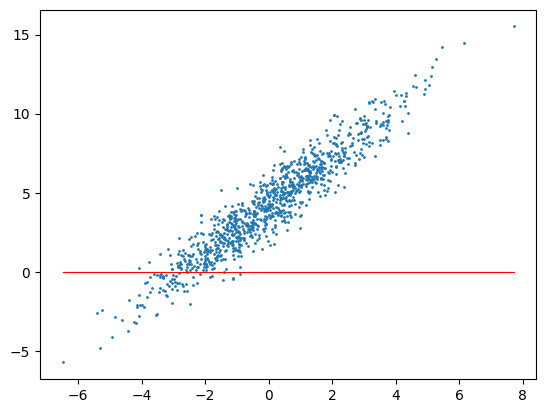

In [ ]:
def visualize(X, y, y_pred):
  plt.scatter(X, y, 1)
  X_, y_pred_= zip(*sorted(zip(X, y_pred)))
  plt.plot(X_, y_pred_, c='r', linewidth=0.8)
  plt.show()

visualize(X_train, y_train, y_train_pred)

Vemos que la predicción es completamente érronea, esto debido a que los parámetros fueron inicializados de forma aleatoria. Mediante un algoritmo de optimización podremos mejorar el modelo actual.

A continuación, usaremos el algoritmo de gradiente descendente para actualizar los parámetros haciendo uso del gradiente de la función de pérdida. Existen diferentes variantes de gradiente descendente, en este notebook cubriremos la más simple, y tal vez, la más ineficiente. Sin embargo, nos ayudará a entender mejor el algoritmo, más adelante veremos variaciones más eficientes que se usan en deep learning.

#### Batch Gradient Descent
En esta versión de gradiente descendente, todos los datos de entrenamiento se tienen en cuenta para dar un solo paso en el algoritmo. La siguiente figura muestra un ejemplo de como se calculan los gradientes usando toda la data como un lote:

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1Yfxo1qEFK1gWbaLL2zFLE0a-Novihm9Z" width="800px" />
<p/>

Tomamos el promedio de los gradientes de todos los ejemplos de entrenamiento y luego usamos ese gradiente promedio para actualizar los parámetros. El gradiente es multiplicado por un valor positivo predeterminado llamado taza de aprendizaje ($\eta$). De esta forma realizamos solo un paso de gradiente descendente en una época.

Podemos expresar el paso matemáticamente de la siguiente manera ($\nabla$ denota el gradiente):

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{n} \sum_{i=0}^n  \nabla_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$

En su forma vectorial tenemos lo siguiente:

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{n} \nabla_{(\mathbf{w},b)} \mathcal{L}(\mathbf{w},b).$$

donde $\nabla$ es el vector gradiente de la función de costo.


#### Gradiente de la función de pérdida

Para poder ejecutar el algoritmo de gradiente descendente, necesitamos calcular el gradiente de la función de pérdida con respecto a los parámetros del modelo. El gradiente del error cuadrático medio (MSE) con respecto a los pesos, está dado por lo siguiente:

$$ \nabla_{\mathbf{w}} \mathcal{L}(\mathbf{w},b)= \frac{1}{n} \sum_{i=0}^{n} (\hat y^{(i)} - y^{(i)}) \mathbf{x} = \frac{1}{n} \mathbf X^\top (\hat y - y),$$

donde $\hat y = \mathbf{Xw} + b$. El gradiente con respecto al bias, está dado por lo siguiente:

$$ \nabla_{b} \mathcal{L}(\mathbf{w},b) = \frac{1}{n} \sum_{i=0}^{n} (\hat y^{(i)} - y^{(i)}) \mathbf{1} = \frac{1}{n} \mathbf 1^\top (\hat y - y),$$

donde $ \mathbf{1}$ es una matriz columna de unos creada a partir del gradiente con respecto al bias el cual es igual a $1$ para todas las muestras. Procedemos a implementar el gradiente:

In [ ]:
def gradient(X, y_pred, y_true):
    n = X.shape[0]

    # TODO: Implementar el gradiente de la función de pérdida con respecto a los pesos
    w_grad = X.T @ (y_pred - y_true) / n

    # TODO: Implementar el gradiente de la función de pérdida con respecto al intercepto
    b_grad = np.sum(y_pred - y_true, axis= 0) /n

    return w_grad, b_grad

Ahora implementaremos un paso de gradiente descendente, donde actualizaremos los parámetros acorde al algoritmo:

In [ ]:
def gradient_descent_step(w, b, w_grad, b_grad, learning_rate):
    w -= learning_rate * w_grad # w = w - learning * grad
    b -= learning_rate * b_grad # b = b - learning * grad

### Entrenamiento

Ahora que tenemos todas las partes en su lugar, estamos listos para implementar el algoritmo de entrenamiento principal. Es crucial que comprenda este código porque verá formas de entrenamiento casi idénticos una y otra vez a lo largo del curso. El algoritmo está dado por lo siguiente:

* Inicializar los parámetros $(\mathbf{w}, b)$
* Iterar por un determinado número de épocas. Para todo el conjunto de datos:

  * Calcular predicciones $\hat y \leftarrow \mathbf{X}\mathbf{w} + b$
  * Calcular el gradiente $\mathbf{g} \leftarrow \nabla_{(\mathbf{w},b)} \frac{1}{n} \sum_{i=0}^{n} l(\hat{y}^{(i)}, y^{(i)}, \mathbf{w}, b)$
  * Actualizar los parámetros $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

En cada *época*, iteraremos a través de todo el conjunto de datos. El número de épocas, `num_epochs`, y la tasa de aprendizaje, `lr`, son hiperparámetros que debemos definir previo al entrenamiento. Desafortunadamente, definir los valores de los hiperparámetros es complicado y requiere algunos ajustes por prueba y error.

#### Fase de entrenamiento

Ahora usaremos los métodos previamente implementados para realizar el entrenamiento.

In [ ]:
# Definimos los hiperparámetros que se usarán en el entrenamiento
num_epochs = 30
learning_rate = 0.1

In [ ]:
def train_model(X_train, y_train, model, num_epochs, learning_rate, show_plot = False):
    n, m = X_train.shape

    # TODO: Inicializar los parámetros usando el método antes implementado
    w, b = initialize_params(m)

    for epoch in range(num_epochs):
        # TODO: Predecir las salidas del modelo usando el método antes implementado
        y_pred = model(X_train, w, b)

        # TODO: Calcular el error MSE usando el método antes implementado
        loss = mse(y_train, y_pred)

        # TODO: Calcular el gradiente usando el método antes implementado
        w_grad, b_grad = gradient(X_train, y_pred, y_train)

        # TODO: Actualizar los parametros usando un paso de gradiente descendente
        gradient_descent_step(w, b, w_grad, b_grad, learning_rate)

        # Imprimimos el error
        if (epoch ) % 2 == 0:
            print(f'epoch {epoch+1}: loss = {loss.item():.8f}')
            if show_plot:
                visualize(X_train, y_train, y_pred)

    return w, b

epoch 1: loss = 28.03533367


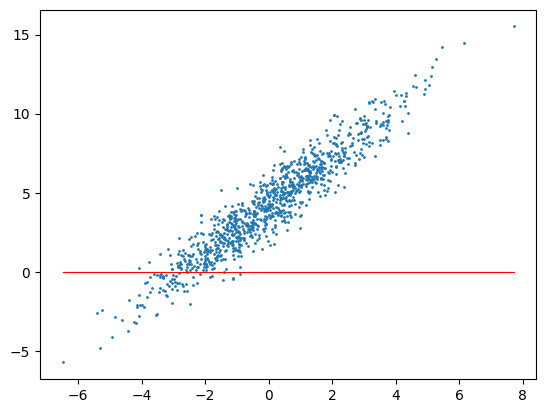

epoch 3: loss = 13.94905889


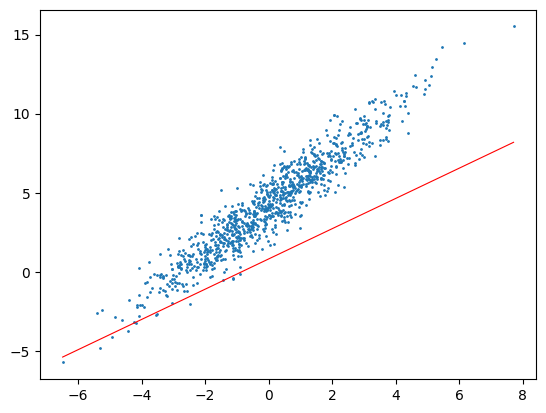

epoch 5: loss = 8.79686924


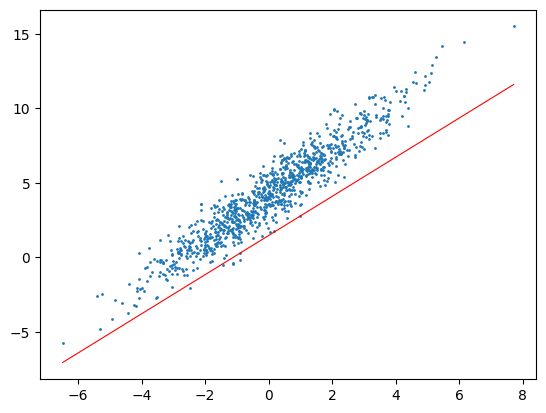

epoch 7: loss = 6.00735275


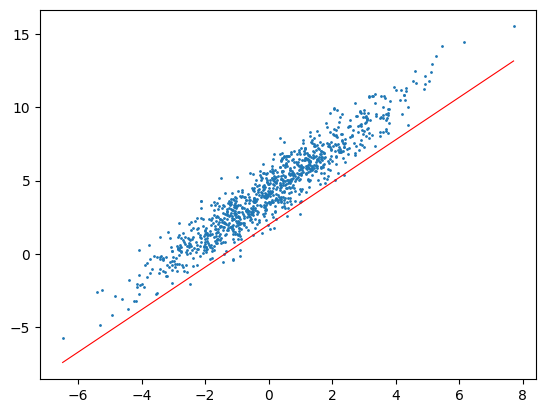

epoch 9: loss = 4.26226066


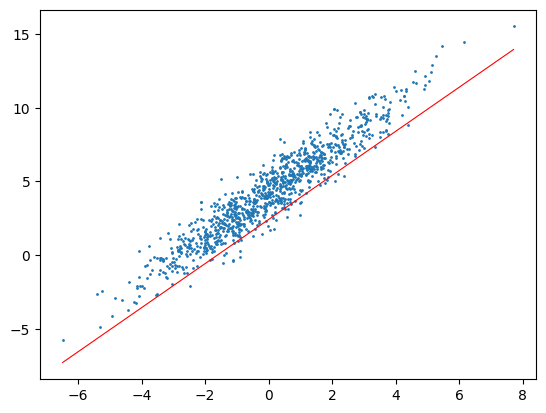

epoch 11: loss = 3.12940466


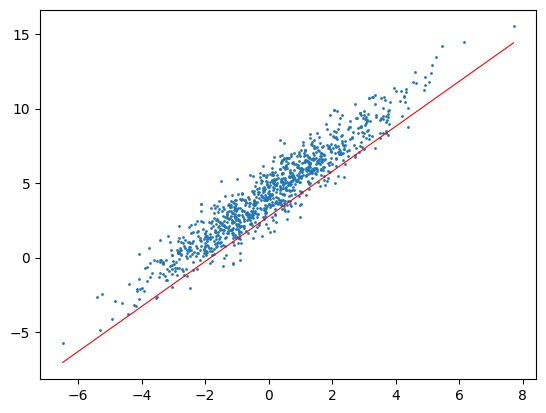

epoch 13: loss = 2.38775165


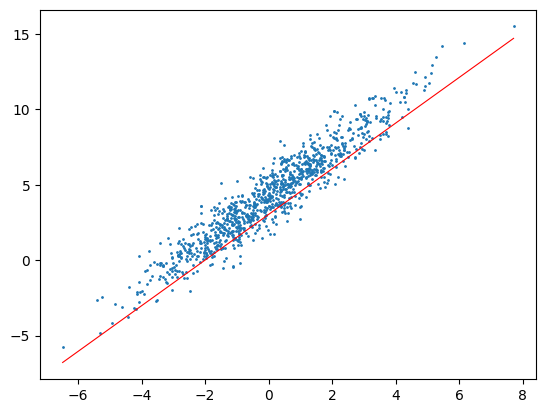

epoch 15: loss = 1.90129753


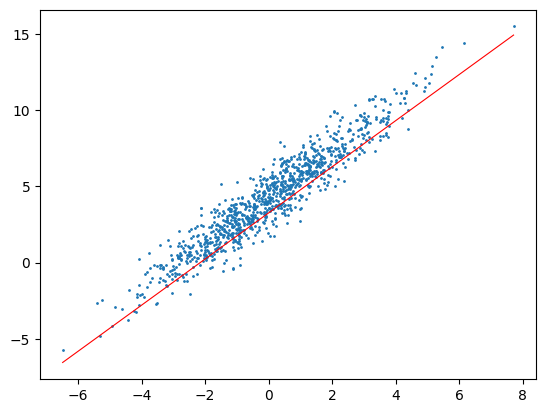

epoch 17: loss = 1.58209752


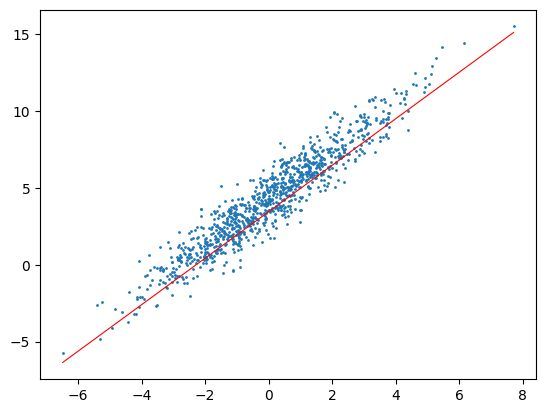

epoch 19: loss = 1.37262669


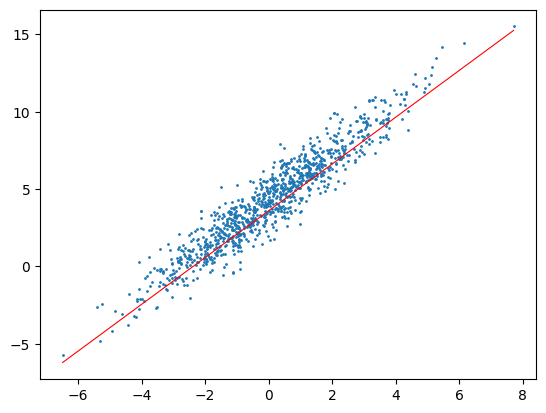

epoch 21: loss = 1.23516144


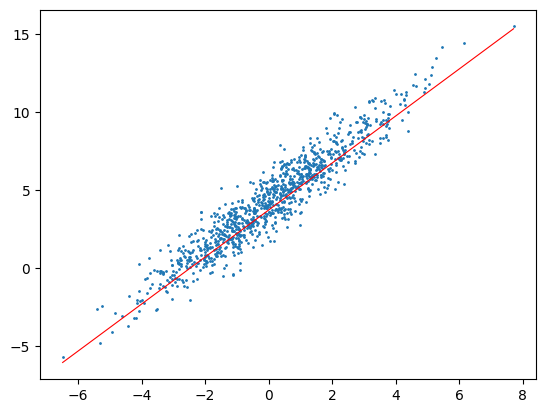

epoch 23: loss = 1.14494945


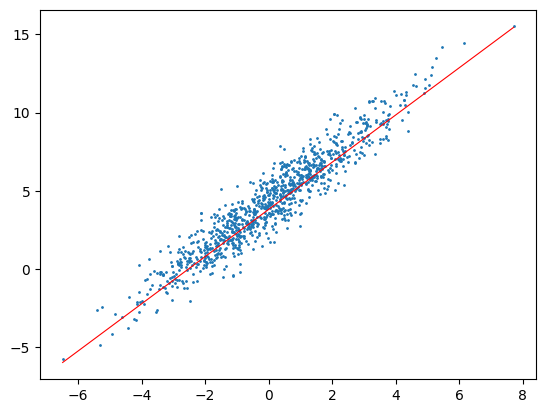

epoch 25: loss = 1.08574750


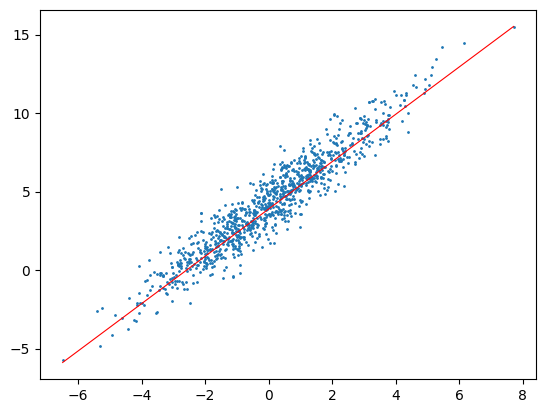

epoch 27: loss = 1.04689599


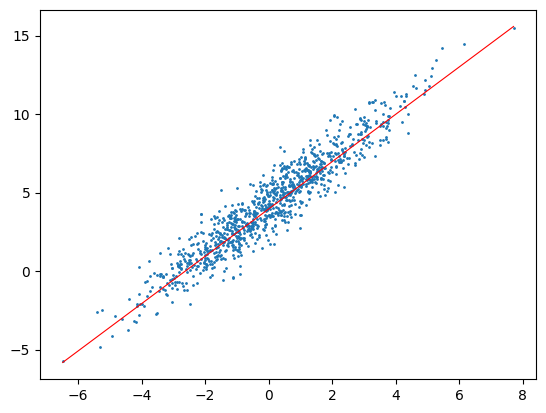

epoch 29: loss = 1.02139954


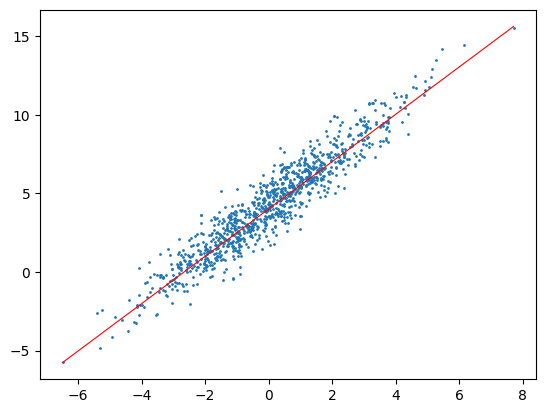


w: [[1.50647928]], b: [4.05202266]


In [ ]:
# Definimos los hiperparámetros que se usarán en el entrenamiento
num_epochs = 30
learning_rate = 0.1

# Entrenamos el modelo usando la data de entrenamiento
w, b = train_model(X_train, y_train, model, num_epochs, learning_rate, True)

print(f'\nw: {w}, b: {b}')

In [ ]:
# Definimos los hiperparámetros que se usarán en el entrenamiento
num_epochs = 50
learning_rate = 0.1
# Entrenamos el modelo usando la data de entrenamiento
w, b = train_model(X_train, y_train, model, num_epochs, learning_rate, False)
print(f'\nw: {w}, b: {b}')

epoch 1: loss = 28.03533367
epoch 3: loss = 13.94905889
epoch 5: loss = 8.79686924
epoch 7: loss = 6.00735275
epoch 9: loss = 4.26226066
epoch 11: loss = 3.12940466
epoch 13: loss = 2.38775165
epoch 15: loss = 1.90129753
epoch 17: loss = 1.58209752
epoch 19: loss = 1.37262669
epoch 21: loss = 1.23516144
epoch 23: loss = 1.14494945
epoch 25: loss = 1.08574750
epoch 27: loss = 1.04689599
epoch 29: loss = 1.02139954
epoch 31: loss = 1.00466740
epoch 33: loss = 0.99368687
epoch 35: loss = 0.98648085
epoch 37: loss = 0.98175187
epoch 39: loss = 0.97864846
epoch 41: loss = 0.97661184
epoch 43: loss = 0.97527530
epoch 45: loss = 0.97439819
epoch 47: loss = 0.97382258
epoch 49: loss = 0.97344483

w: [[1.50433785]], b: [4.20902291]


Podemos ver que la solución es bastante cercana la valor real ($\mathbf{w} = [1.5]^\top$ y $b = 4.2$).

In [ ]:
print(f'error en estimar w: {true_w - w.reshape(true_w.shape)}')
print(f'error en estimar b: {true_b - b}')

error en estimar w: [-0.00647928]
error en estimar b: [0.14797734]


Tener en cuenta que no debemos dar por sentado que podemos recuperar los parámetros a la perfección. Sin embargo, en machine learning normalmente estamos menos preocupados por recuperar los parámetros subyacentes verdaderos y más preocupados por los parámetros que conducen a una predicción precisa. Afortunadamente, incluso en problemas difíciles de optimización, gradiente descendente a menudo puede encontrar soluciones notablemente buenas, debido en parte al hecho de que, para las redes profundas, existen muchas configuraciones de los parámetros que conducen a una predicción muy precisa.

#### Predicción

Usando los parámetros calculados, podemos realizar predicciones para nuevos datos. Para ello, implemente la siguiente función:

In [ ]:
def predict(X, w, b):
    return X@w + b

Ahora realice la predicción para los datos de entrenamiento:

In [ ]:
y_train_pred = predict(X_train, w, b)

También podemos visualizar la solución encontrada analíticamente:

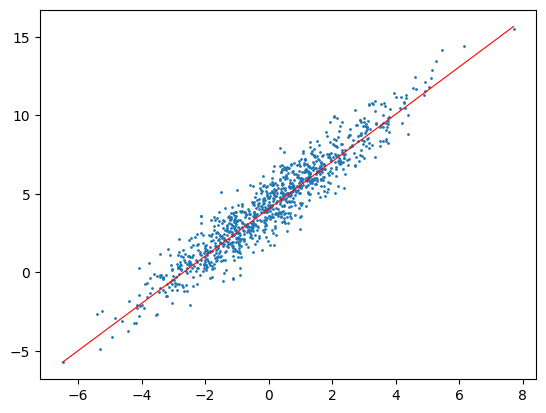

In [ ]:
visualize(X_train, y_train, y_train_pred)

El error de entrenamiento es el siguiente:

In [ ]:
print(f"MSE de entrenamiento: {mse(y_train, y_train_pred):.3f}")

MSE de entrenamiento: 1.005


#### Predicción para la data de prueba

Podemos hacer predecciones para la data de prueba, para ello primero debemos realizar todo tipo de preprocesamiento que se aplicó a la data de entrenamiento, en este caso se aumenta columan de unos. Luego se realizan las predicciones.

In [ ]:
# TODO: Realizar predicciones usando los parámetros hallados
#       con la data de entrenamiento
y_test_pred = predict(X_test, w, b)

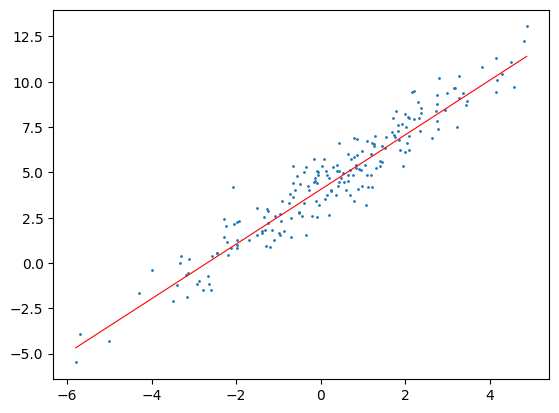

In [ ]:
visualize(X_test, y_test, y_test_pred)

El error de prueba es el siguiente:

In [ ]:
print(f"MSE de prueba: {mse(y_test, y_test_pred):.3f}")

## SGD usando scikit-learn

Hasta este momento hemos realizado una implementación usando solamente operaciones sobre arreglos de Numpy, todos los métodos tuvimos que implementarlos. Sin embargo, scikit-learn ofrece una implementación de SGD que facilitará todo el proceso.

### SGDRegressor

SGDRegressor es un modelo de regresión lineal proporcionado por la biblioteca scikit-learn en Python que utiliza el Descenso de gradiente estocástico (SGD) para la optimización. Para usarlo es necesario importar el estimador [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html).

In [ ]:
from sklearn.linear_model import SGDRegressor

Ahora inicializamos el modelo

In [ ]:
# Initializar SGDRegressor
sgd_regressor = SGDRegressor(max_iter=40, random_state=42, penalty=None, eta0=0.01)

Para entrenar y probar el modelo es necesario tener las etiquetas como vectores no matrices

In [ ]:
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

Ahora entrenamos el modelo en la data de entrenamiento

In [ ]:
# Entrenar modelo
sgd_regressor.fit(X_train, y_train)

SGDRegressor(max_iter=40, penalty=None, random_state=42)

### Predicciones de entrenamiento

In [ ]:
y_train_pred = sgd_regressor.predict(X_train)

Visualizamos el modelo lineal en la data

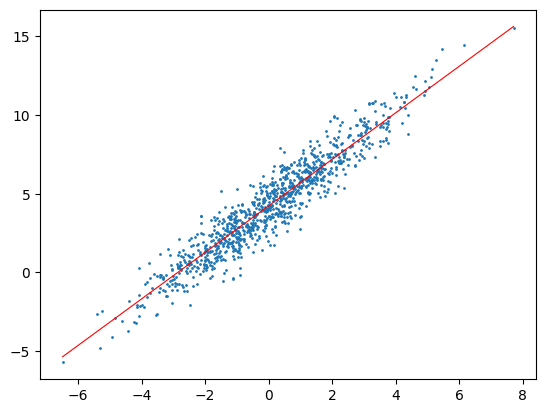

In [ ]:
visualize(X_train, y_train, y_train_pred)

Obtenemos el error de entrenamiento

In [ ]:
print(f"MSE de entrenamiento: {mse(y_train, y_train_pred):.3f}")

MSE de entrenamiento: 0.975


In [ ]:
print(sgd_regressor.coef_)
print(sgd_regressor.intercept_)

[1.48012762]
[4.22801453]


### Predicciones en la data de prueba

In [ ]:
y_test_pred = sgd_regressor.predict(X_test)

Visualizamos el modelo lineal en la data

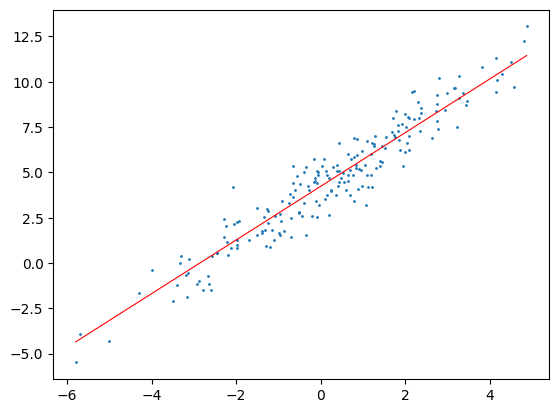

In [ ]:
visualize(X_test, y_test, y_test_pred)

Obtenemos el error de prueba

In [ ]:
print(f"MSE de entrenamiento: {mse(y_test, y_test_pred):.3f}")

MSE de entrenamiento: 0.944
